In [1]:
%matplotlib inline



# The Spectrum and EpochsSpectrum classes: frequency-domain data

This tutorial shows how to create and visualize frequency-domain
representations of your data, starting from continuous :class:`~mne.io.Raw`,
discontinuous :class:`~mne.Epochs`, or averaged :class:`~mne.Evoked` data.

As usual we'll start by importing the modules we need, and loading our
`sample dataset <sample-dataset>`:


In [2]:
import numpy as np

import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False).crop(tmax=60)

In [3]:
mne.sys_info()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f57af015f70>
Traceback (most recent call last):
  File "/opt/anaconda3/anaconda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/anaconda3/anaconda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/anaconda3/anaconda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/anaconda3/anaconda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Platform:         Linux-5.4.0-91-generic-x86_64-with-glibc2.10
Python:           3.8.5 (default, Sep  4 2020, 07:30:14)  [GCC 7.3.0]
Executable:       /opt/anaconda3/anaconda/bin/python
CPU:              x86_64: 4 cores
Memory:           7.7 GB

mne:              1.3.0
numpy:            1.22.1 {OpenBLAS 0.3.17 with 4 threads}
scipy:            1.7.3
matplotlib:       3.5.3 {backend=module://ipykernel.pylab.backend_inline}

sklearn:          0.23.2
numba:            0.51.2
nibabel:          Not found
nilearn:          Not found
dipy:             Not found
openmeeg:         Not found
cupy:             Not found
pandas:           1.1.3
pyvista:          Not found
pyvistaqt:        Not found
ipyvtklink:       Not found
vtk:              Not found
qtpy:             1.9.0 {PyQt5=5.9.7}
ipympl:           Not found
pyqtgraph:        0.11.1
pooch:            v1.5.2

mne_bids:         Not found
mne_nirs:         Not found
mne_features:     Not found
mne_qt_browser:   Not found
mne_connectivity: 

All three sensor-space containers (:class:`~mne.io.Raw`,
:class:`~mne.Epochs`, and :class:`~mne.Evoked`) have a
:meth:`~mne.io.Raw.compute_psd` method with the same options.



In [4]:
raw.compute_psd()

Effective window size : 0.426 (s)


<Power Spectrum (from Raw, welch method) | 364 channels × 129 freqs, 0.0-300.3 Hz>

By default, the spectral estimation method will be the
:footcite:t:`Welch1967` method for continuous data, and the multitaper
method :footcite:`Slepian1978` for epoched or averaged data. This default can
be overridden by passing ``method='welch'`` or ``method='multitaper'`` to the
:meth:`~mne.io.Raw.compute_psd` method.

There are many other options available as well; for example we can compute a
spectrum from a given span of times, for a chosen frequency range, and for a
subset of the available channels:



In [5]:
raw.compute_psd(method='multitaper', tmin=10, tmax=20, fmin=5, fmax=30,
                picks='eeg')

    Using multitaper spectrum estimation with 7 DPSS windows


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,multitaper
Number of channels,59
Number of frequency bins,250
Frequency range,5.10 – 30.00 Hz


You can also pass some parameters to the underlying spectral estimation
function, such as the FFT window length and overlap for the Welch method; see
the docstrings of :class:`mne.time_frequency.Spectrum` (esp. its
``method_kw`` parameter) and the spectral estimation functions
:func:`~mne.time_frequency.psd_array_welch` and
:func:`~mne.time_frequency.psd_array_multitaper` for details.

For epoched data, the class of the spectral estimate will be
:class:`mne.time_frequency.EpochsSpectrum` instead of
:class:`mne.time_frequency.Spectrum`, but most of the API is the same for the
two classes. For example, both have a
:meth:`~mne.time_frequency.EpochsSpectrum.get_data` method with an option to
return the bin frequencies:



In [6]:
with mne.use_log_level('WARNING'):  # hide some irrelevant info messages
    events = mne.find_events(raw, stim_channel='STI 014')
    event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
                  'visual/right': 4}
    epochs = mne.Epochs(raw, events, tmin=-0.3, tmax=0.7, event_id=event_dict,
                        preload=True)
epo_spectrum = epochs.compute_psd()
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f'\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}')
epo_spectrum

    Using multitaper spectrum estimation with 7 DPSS windows

PSDs shape: (77, 364, 301), freqs shape: (301,)


<Power Spectrum (from Epochs, multitaper method) | 77 epochs × 364 channels × 301 freqs, 0.0-299.8 Hz>

Additionally, both :class:`~mne.time_frequency.Spectrum` and
:class:`~mne.time_frequency.EpochsSpectrum` have ``__getitem__`` methods,
meaning their data can be accessed by square-bracket indexing. For
:class:`~mne.time_frequency.Spectrum` objects (computed from
:class:`~mne.io.Raw` or :class:`~mne.Evoked` data), the indexing works
similar to a :class:`~mne.io.Raw` object or a
:class:`NumPy array<numpy.ndarray>`:



In [7]:
evoked = epochs['auditory'].average()
evk_spectrum = evoked.compute_psd()
# the first 3 frequency bins for the first 4 channels:
print(evk_spectrum[:4, :3])

    Using multitaper spectrum estimation with 7 DPSS windows
[[5.61863537e-23 1.13487136e-22 9.88010499e-23]
 [2.89065956e-23 4.24056397e-23 3.91160668e-23]
 [1.56762015e-25 2.65842303e-25 2.39426775e-25]
 [5.38758770e-23 1.03771739e-22 9.98519756e-23]]


.. hint::
   :class: sidebar

   If the original :class:`~mne.Epochs` object had a metadata dataframe
   attached, the derived :class:`~mne.time_frequency.EpochsSpectrum` will
   inherit that metadata and will hence also support subselecting epochs via
   `Pandas query strings <pandas:indexing.query>`.

In contrast, the :class:`~mne.time_frequency.EpochsSpectrum` has indexing
similar to :class:`~mne.Epochs` objects: you can use string values to select
spectral estimates for specific epochs based on their condition names, and
what you get back is a new instance of
:class:`~mne.time_frequency.EpochsSpectrum` rather than a
:class:`NumPy array<numpy.ndarray>` of the data values. Selection via
:term:`hierarchical event descriptors` (HEDs) is also possible:



In [8]:
# get both "visual/left" and "visual/right" epochs:
epo_spectrum['visual']

<Power Spectrum (from Epochs, multitaper method) | 37 epochs × 364 channels × 301 freqs, 0.0-299.8 Hz>

## Visualizing Spectrum objects

Both :class:`~mne.time_frequency.Spectrum` and
:class:`~mne.time_frequency.EpochsSpectrum` objects have plotting methods
:meth:`~mne.time_frequency.Spectrum.plot` (frequency × power),
:meth:`~mne.time_frequency.Spectrum.plot_topo` (frequency × power separately
for each sensor), and :meth:`~mne.time_frequency.Spectrum.plot_topomap`
(interpolated scalp topography of power, in specific frequency bands). A few
plot options are demonstrated below; see the docstrings for full details.



/opt/anaconda3/anaconda/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


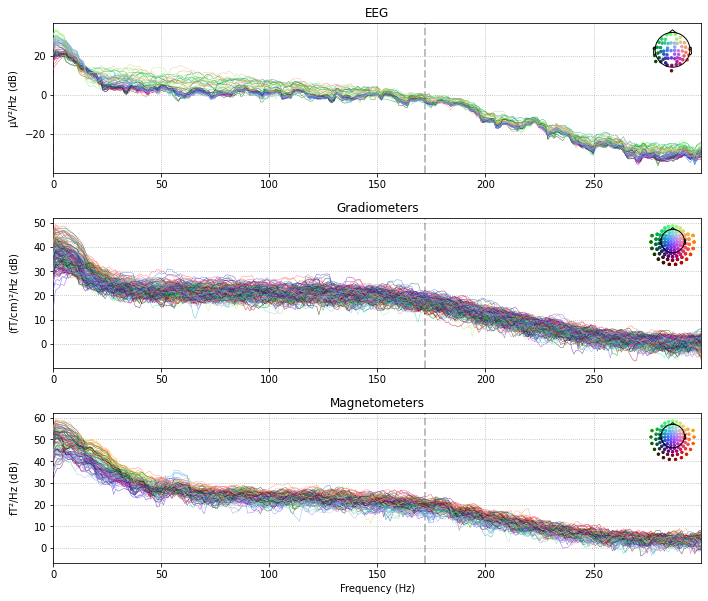

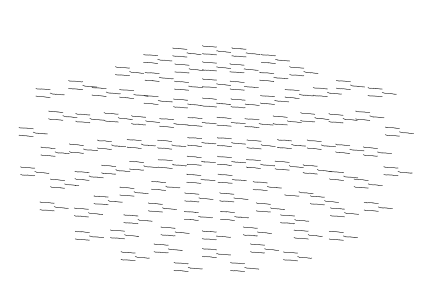

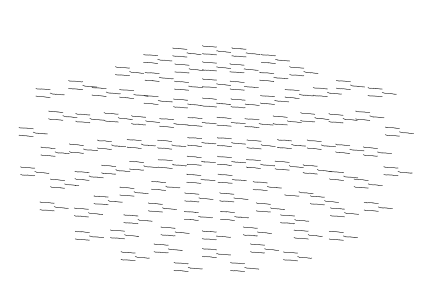

In [9]:
evk_spectrum.plot()
evk_spectrum.plot_topo(color='k', fig_facecolor='w', axis_facecolor='w')

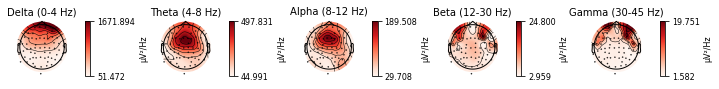

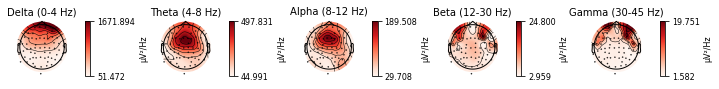

In [18]:
evk_spectrum.plot_topomap(ch_type='eeg', agg_fun=np.median)

## Migrating legacy code

Below is a quick-reference table of equivalent code from before and after the
introduction of the :class:`~mne.time_frequency.Spectrum` and
:class:`~mne.time_frequency.EpochsSpectrum` classes.

.. table:: Quick reference for common Spectral class actions
   :widths: auto

   +---------------------------------------------------+----------------------------------------------------------------------+
   | Old                                               | New                                                                  |
   +===================================================+======================================================================+
   | ``mne.time_frequency.psd_welch(raw)``             | ``raw.compute_psd().get_data(return_freqs=True)``                    |
   +---------------------------------------------------+----------------------------------------------------------------------+
   | ``mne.time_frequency.psd_multitaper(raw)``        | ``raw.compute_psd(method='multitaper').get_data(return_freqs=True)`` |
   +---------------------------------------------------+----------------------------------------------------------------------+
   | ``raw.plot_psd(fmin, fmax, dB, area_mode='std')`` | ``raw.compute_psd(fmin, fmax).plot(dB, ci='std')``                   |
   +---------------------------------------------------+----------------------------------------------------------------------+
   | ``raw.plot_psd_topo(n_fft, overlap, axes)``       | ``raw.compute_psd(n_fft, overlap).plot_topo(axes)``                  |
   +---------------------------------------------------+----------------------------------------------------------------------+
   | ``epochs.plot_psd_topomap(tmax, bands)``          | ``epochs.compute_psd(tmax).plot_topomap(bands)``                     |
   +---------------------------------------------------+----------------------------------------------------------------------+


<div class="alert alert-danger"><h4>Warning</h4><p>The functions ``mne.time_frequency.psd_welch`` and
   ``mne.time_frequency.psd_multitaper`` have been removed; new code
   should use the :meth:`Raw.compute_psd()<mne.io.Raw.compute_psd>`,
   :meth:`Epochs.compute_psd()<mne.Epochs.compute_psd>`, and
   :meth:`Evoked.compute_psd()<mne.Evoked.compute_psd>` methods, and pass
   ``method='welch'`` or ``method='multitaper'`` as a parameter.

   The class methods :meth:`Raw.plot_psd()<mne.io.Raw.plot_psd>`,
   :meth:`Epochs.plot_psd()<mne.Epochs.plot_psd>`,
   :meth:`Raw.plot_psd_topo()<mne.io.Raw.plot_psd_topo>`, and
   :meth:`Epochs.plot_psd_topomap()<mne.Epochs.plot_psd_topomap>` have been
   kept in the API to support legacy code, but should be avoided when writing
   new code.</p></div>


## References
.. footbibliography::

